#Imports and Variables Value Initializer

In [ ]:
!pip install Sastrawi

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
vocab_size = 20000
embedding_dim = 100
max_length = 50
trunc_type = 'post'
oov_tok = "<OOV>"

In [ ]:
'''
Project: Bangkit Capstone Project
Group: B21-CAP0194
Part: Modelling
'''

'\nProject: Bangkit Capstone Project\nGroup: B21-CAP0194\nPart: Modelling\n'

#Translate the Dataset (Post)

In [ ]:
#Import Labelled Post Dataset
url_post = 'https://drive.google.com/file/d/1VPg3UmXkT0cGEIbifhoiI4JKz3M7NX-w/view?usp=sharing'
file_id_post = url_post.split('/')[-2]
csv_url_post = 'https://drive.google.com/uc?id=' + file_id_post
df_post = pd.read_csv(csv_url_post)
df_post.head()

,text,label,index
0,the ironies of the movement are too painfully ...,Lokasi Kerja,0
1,women in kuwait have launched a social media c...,Siber,1
2,triger warning raising awareness of sexual ass...,Lokasi Privat,2
3,charges brought against the guy that smacked m...,Lokasi Privat,3
4,and the fourth presenter on th may is hannah b...,Lokasi Pendidikan,4


In [ ]:
#Warning! It's not free, please think several times before running this cell below
#Enter the API Key
import getpass

APIKEY = getpass.getpass()

··········


In [ ]:
#Warning! It's also not free, please think several times before running this cell below
#Running Translate API
from googleapiclient.discovery import build
service = build('translate', 'v2', developerKey=APIKEY)

df_post['indo_text'] = df_post['text'].apply(lambda x: (service.translations().list(source='en', target='id', q=x).execute())).apply(lambda x: x['translations']).apply(lambda x: x[0]).apply(lambda x: x['translatedText'])

In [ ]:
#Show the first 50 data in the dataset
df_post['indo_text'].head(50)

0     ironi gerakan ini terlalu menyakitkan jelas di...
1     wanita di kuwait telah meluncurkan kampanye me...
2     peringatan triger meningkatkan kesadaran akan ...
3     dakwaan yang diajukan terhadap pria yang memuk...
4     dan presenter keempat pada bulan Mei adalah ma...
5     Ini sangat kacau, adakah pria di mata publik, ...
6     untuk mengatasi epidemi kekerasan laki-laki te...
7     Ada serangkaian tuduhan pelecehan baru terhada...
8     ingin melihat seperti apa gerakan para wanita ...
9     siswa perempuan tidak ingin berhubungan seks d...
10    ketika kita berbicara tentang dan kekerasan, k...
11    mengambil jutaan tahun lalu dalam dana nih nih...
12    bantu siswa Anda untuk memerangi pelecehan den...
13    Saya masih ingin berbicara dengan wanita penya...
14    glenn greenwald tidak suka gerakan mendukung m...
15    untuk lebih lanjut tentang topik ini bergabung...
16    apa hubungan gerakan itu dengan pembunuhan ma ...
17    opini terbaru dari dan cuomo membutuhkan w

In [ ]:
#Convert the text into lowercase
df_post['indo_text'] = df_post['indo_text'].str.lower()

In [ ]:
#Save DataFrame to CSV
df_post.to_csv("capstonetweetposttranslated.csv", index=False)

#Applying Stopwords and Stemmer (Post)

In [ ]:
#Import Translated Post Dataset
url_post = 'https://drive.google.com/file/d/1dWQB76NUK2DsPSYvxPD2KJQ12bKM7hmA/view?usp=sharing'
file_id_post = url_post.split('/')[-2]
csv_url_post = 'https://drive.google.com/uc?id=' + file_id_post
df_post = pd.read_csv(csv_url_post)
df_post.head()

,text,label,index,indo_text
0,the ironies of the movement are too painfully ...,Lokasi Kerja,0,ironi gerakan ini terlalu menyakitkan jelas di...
1,women in kuwait have launched a social media c...,Siber,1,wanita di kuwait telah meluncurkan kampanye me...
2,triger warning raising awareness of sexual ass...,Lokasi Privat,2,peringatan triger meningkatkan kesadaran akan ...
3,charges brought against the guy that smacked m...,Lokasi Privat,3,dakwaan yang diajukan terhadap pria yang memuk...
4,and the fourth presenter on th may is hannah b...,Lokasi Pendidikan,4,dan presenter keempat pada bulan mei adalah ma...


In [ ]:
#Import Translated Additional Dataset
url_add = 'https://drive.google.com/file/d/1Sb1t9O3Y09SuAz4buHLlf4qa9HrOimJi/view?usp=sharing'
file_id_add = url_add.split('/')[-2]
csv_url_add = 'https://drive.google.com/uc?id=' + file_id_add
df_add = pd.read_csv(csv_url_add)
df_add.drop(columns=['label_laporan'], inplace=True)
df_add.rename(columns={'label_post': 'label'}, inplace = True)
df_add.head()

,index,text,label,indo_text
0,0,x,Netral,x
1,1,on how the other accused were doing after that...,Lokasi Publik,tentang apa yang dilakukan terdakwa lainnya se...
2,2,in the five years since black women have emerg...,Lokasi Publik,dalam lima tahun sejak perempuan kulit hitam m...
3,3,discussed the movement and how to deal with tr...,Lokasi Publik,membahas pergerakan dan cara mengatasi trauma ...
4,4,charlie hanson publicly supported and spoke ou...,Lokasi Kerja,charlie hanson secara terbuka mendukung dan be...


In [ ]:
#Combine 2 datasets
df_post = pd.concat([df_post, df_add])

In [ ]:
#Drop duplicates row
df_post.drop_duplicates(subset=['text'], inplace=True)

In [ ]:
df_post['label'].value_counts()

Netral               5490
Lokasi Publik        4416
Lokasi Privat        3635
Siber                2788
Lokasi Kerja         2224
Lokasi Pendidikan    2109
Name: label, dtype: int64

In [ ]:
df_post['text'] = df_post['indo_text']
df_post = df_post.drop(['indo_text'], axis=1)

In [ ]:
df_post['text']

0       ironi gerakan ini terlalu menyakitkan jelas di...
1       wanita di kuwait telah meluncurkan kampanye me...
2       peringatan triger meningkatkan kesadaran akan ...
3       dakwaan yang diajukan terhadap pria yang memuk...
4       dan presenter keempat pada bulan mei adalah ma...
                              ...                        
3961                                     khusus kasus dan
3963    wanita yang menyusun surat perlindungan saya m...
3964    daftar di bookmad yang disorot untuk keinginan...
3965    mereka mencoba melakukan pr untuknya pada kita...
3966    saya terkadang bertanya-tanya apakah saya tahu...
Name: text, Length: 20662, dtype: object

In [ ]:
#Remove Stopwords from Texts
stopwordFactory = StopWordRemoverFactory()
stopword = stopwordFactory.create_stop_word_remover()

df_post['text'] = df_post['text'].apply(lambda x: stopword.remove(x))

In [ ]:
df_post['text']

0       ironi gerakan terlalu menyakitkan jelas dipelo...
1       wanita kuwait meluncurkan kampanye media sosia...
2       peringatan triger meningkatkan kesadaran pelec...
3       dakwaan diajukan pria memukul serangan seksual...
4       presenter keempat bulan mei mahasiswa phd hann...
                              ...                        
3961                                         khusus kasus
3963    wanita menyusun surat perlindungan melindungi ...
3964    daftar bookmad disorot keinginan membara buku ...
3965    mencoba melakukan pr untuknya kita bagaimana k...
3966    terkadang bertanya-tanya tahu siapa pemerkosa ...
Name: text, Length: 20662, dtype: object

In [ ]:
#Stem the Texts (Removing Prefix and Suffix)
stemmerFactory = StemmerFactory()
stemmer = stemmerFactory.create_stemmer()

df_post['text'] = df_post['text'].apply(lambda x: stemmer.stem(x))

In [ ]:
df_post['text']

0       ironi gera terlalu sakit jelas lopor aktris ho...
1       wanita kuwait luncur kampanye media sosial man...
2       ingat triger tingkat sadar leceh seksual keras...
3       dakwa aju pria pukul serang seksual persetan b...
4       presenter empat bulan mei mahasiswa phd hannah...
                              ...                        
3961                                         khusus kasus
3963    wanita susun surat lindung lindung ip litigasi...
3964    daftar bookmad sorot ingin bara buku tampil ed...
3965    coba laku pr untuk kita bagaimana korban leceh...
3966    terkadang tanya tahu siapa perkosa saya orang ...
Name: text, Length: 20662, dtype: object

In [ ]:
#Save DataFrame to CSV
df_post.to_csv("capstonetweetpoststemmed.csv", index=False)

#Modelling (Post)

In [ ]:
#Import Stemmed Dataset
url_post = 'https://drive.google.com/file/d/1hbaRpS73f0220FBXvSSkWSHvAOlwN8y5/view?usp=sharing'
file_id_post = url_post.split('/')[-2]
csv_url_post = 'https://drive.google.com/uc?id=' + file_id_post
df_post = pd.read_csv(csv_url_post)
df_post.head()

,text,label,index
0,ironi gera terlalu sakit jelas lopor aktris ho...,Lokasi Kerja,0
1,wanita kuwait luncur kampanye media sosial man...,Siber,1
2,ingat triger tingkat sadar leceh seksual keras...,Lokasi Privat,2
3,dakwa aju pria pukul serang seksual persetan b...,Lokasi Privat,3
4,presenter empat bulan mei mahasiswa phd hannah...,Lokasi Pendidikan,4


In [ ]:
df_post['text']

0        ironi gera terlalu sakit jelas lopor aktris ho...
1        wanita kuwait luncur kampanye media sosial man...
2        ingat triger tingkat sadar leceh seksual keras...
3        dakwa aju pria pukul serang seksual persetan b...
4        presenter empat bulan mei mahasiswa phd hannah...
                               ...                        
20657                                         khusus kasus
20658    wanita susun surat lindung lindung ip litigasi...
20659    daftar bookmad sorot ingin bara buku tampil ed...
20660    coba laku pr untuk kita bagaimana korban leceh...
20661    terkadang tanya tahu siapa perkosa saya orang ...
Name: text, Length: 20662, dtype: object

In [ ]:
df_post['label'].value_counts()

Netral               5490
Lokasi Publik        4416
Lokasi Privat        3635
Siber                2788
Lokasi Kerja         2224
Lokasi Pendidikan    2109
Name: label, dtype: int64

In [ ]:
labels = pd.get_dummies(df_post.label)

In [ ]:
df_new_post = pd.concat([df_post, labels], axis=1)

In [ ]:
df_new_post.head()

,text,label,index,Lokasi Kerja,Lokasi Pendidikan,Lokasi Privat,Lokasi Publik,Netral,Siber
0,ironi gera terlalu sakit jelas lopor aktris ho...,Lokasi Kerja,0,1,0,0,0,0,0
1,wanita kuwait luncur kampanye media sosial man...,Siber,1,0,0,0,0,0,1
2,ingat triger tingkat sadar leceh seksual keras...,Lokasi Privat,2,0,0,1,0,0,0
3,dakwa aju pria pukul serang seksual persetan b...,Lokasi Privat,3,0,0,1,0,0,0
4,presenter empat bulan mei mahasiswa phd hannah...,Lokasi Pendidikan,4,0,1,0,0,0,0


In [ ]:
tweet_post = df_new_post['text'].astype(str).values
label_post = df_new_post[["Lokasi Kerja", "Lokasi Pendidikan", "Lokasi Privat", "Lokasi Publik", "Netral", "Siber"]].values

In [ ]:
label_post

array([[1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0]], dtype=uint8)

In [ ]:
from sklearn.model_selection import train_test_split
#Train Text, Test Text, Train Label, Test Label
X_train, X_test, y_train, y_test = train_test_split(tweet_post, label_post, test_size=0.1, shuffle=True)

In [ ]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(X_train)
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences, maxlen = max_length)

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs={}):
		if(logs.get('val_accuracy')>0.85):
			print("Desired accuracy reached!")
			self.model.stop_training=True

In [ ]:
import tensorflow as tf
'''
For improvement, we optimized this parameters:
1. embedding_dim = 50, 100
2. max_length = 50, 100
3. Bidirectional layer = 16, 32, 64, 128
4. Dropout value = 0.1, 0.2, 0.3, 0.5, 0.6
5. recurrent_dropout value = 0.2 & 0.3
6. Convolutional layer = 32, 64, 128
7. Convolutional kernel = 1, 2, 3, 4, 5
8. Pooling layer = MaxPooling1D & GlobalMaxPooling1D
9. batch_size = 32, 64, 100

Selected improvement parameters:
1. Embedding_dim = 100
2. Max_length = 50
3. Dropout value = 0.6
4. Convolutional layer = 128
5. Convolutional kernel = 2
6. Pooling layer = GlobalMaxPooling1D
7. batch_size = 64
'''

'''
# Initial Model : Bi-LSTM with Dropout
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(6, activation='softmax')
])
'''

'''
# Improvement : Bi-LSTM with GRU
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
  tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, recurrent_dropout=0.2, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(6, activation='softmax')
])
'''

#Last Improvement : CNN with dropout
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
  tf.keras.layers.Dropout(0.6),
  tf.keras.layers.Conv1D(128, 4, activation='relu',padding='same'),
  tf.keras.layers.Dropout(0.6),
  tf.keras.layers.GlobalMaxPooling1D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.6),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(6, activation='softmax')
])

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 100)           2000000   
_________________________________________________________________
dropout_9 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 50, 128)           51328     
_________________________________________________________________
dropout_10 (Dropout)         (None, 50, 128)           0         
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 128)               0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 128)               0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)              

In [ ]:
num_epochs = 10
callbacks = myCallback()
history = model.fit(padded, y_train, epochs=num_epochs, validation_data=(testing_padded, y_test), callbacks=[callbacks], batch_size=60)

Epoch 1/10
310/310 [==============================] - 7s 21ms/step - loss: 1.6065 - accuracy: 0.3447 - val_loss: 1.5107 - val_accuracy: 0.5530
Epoch 2/10
310/310 [==============================] - 6s 21ms/step - loss: 1.1262 - accuracy: 0.5867 - val_loss: 1.0357 - val_accuracy: 0.7199
Epoch 3/10
310/310 [==============================] - 6s 20ms/step - loss: 0.8606 - accuracy: 0.7068 - val_loss: 0.8820 - val_accuracy: 0.7746
Epoch 4/10
310/310 [==============================] - 6s 20ms/step - loss: 0.7306 - accuracy: 0.7581 - val_loss: 0.8016 - val_accuracy: 0.7799
Epoch 5/10
310/310 [==============================] - 6s 20ms/step - loss: 0.6523 - accuracy: 0.7902 - val_loss: 0.7755 - val_accuracy: 0.7857
Epoch 6/10
310/310 [==============================] - 6s 20ms/step - loss: 0.5908 - accuracy: 0.8094 - val_loss: 0.7332 - val_accuracy: 0.7823
Epoch 7/10
310/310 [==============================] - 6s 20ms/step - loss: 0.5411 - accuracy: 0.8260 - val_loss: 0.7285 - val_accuracy: 0.7804

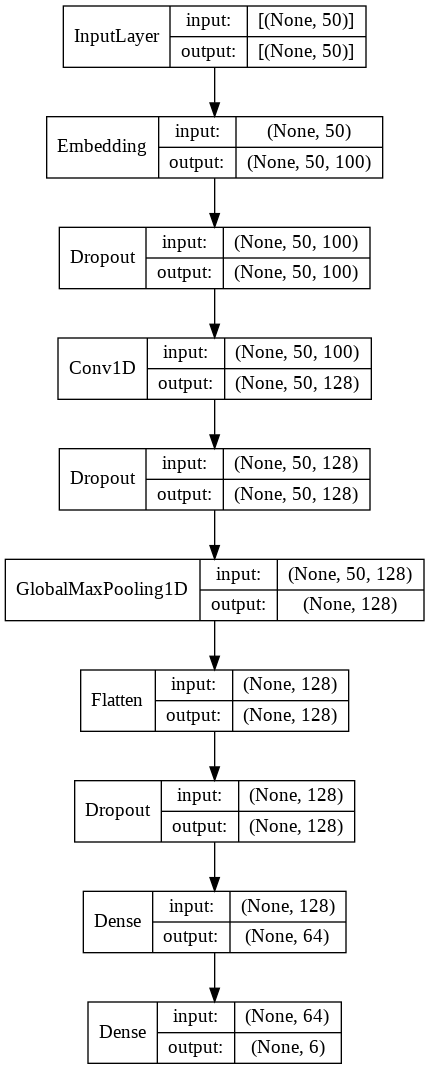

In [ ]:
from keras.utils.vis_utils import plot_model
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=False)

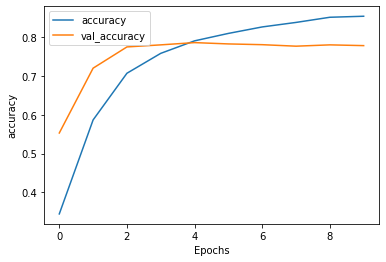

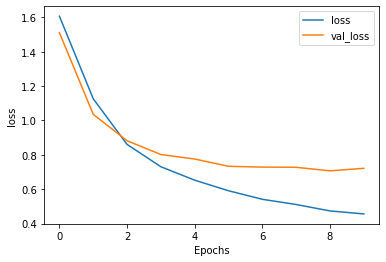

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
text = ["bos di kantor"]

tokenized_text = tokenizer.texts_to_sequences(text)

In [ ]:
prediction = model.predict(tokenized_text)

In [ ]:
labels = ["Lokasi Kerja", "Lokasi Pendidikan", "Lokasi Privat", "Lokasi Publik", "Netral", "Siber"]
predicted = prediction.argmax(axis=1)
predict_labels = [labels[predict] for predict in predicted]
print(prediction)
print(predict_labels)

[[0.85776675 0.07276974 0.00468703 0.04709632 0.01210778 0.00557242]]
['Lokasi Kerja']


In [ ]:
#Exporting the Model (TFLITE)
export_dir = 'saved_model_post/1'
tf.saved_model.save(model, export_dir)


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: saved_model_post/1/assets


In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

In [ ]:
import pathlib

tflite_model_post_file = pathlib.Path('/content/modelpost.tflite')
tflite_model_post_file.write_bytes(tflite_model)

8243728

In [ ]:
from google.colab import files
files.download(tflite_model_post_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Exporting the Tokenized Word
import json

with open( 'word_dict_post.json' , 'w' ) as file:
    json.dump( tokenizer.word_index , file )

#Translate the Dataset (Laporan)

In [ ]:
#Import Labelled Laporan Dataset
url_laporan = 'https://drive.google.com/file/d/1fljXpb0LSiSelHDJLaEDt7rw0e2_ZcoY/view?usp=sharing'
file_id_laporan = url_laporan.split('/')[-2]
csv_url_laporan = 'https://drive.google.com/uc?id=' + file_id_laporan
df_laporan = pd.read_csv(csv_url_laporan)
df_laporan.head()

,text,label,index
0,the ironies of the movement are too painfully ...,Kekerasan Psikis,0
1,women in kuwait have launched a social media c...,Kekerasan Psikis,1
2,triger warning raising awareness of sexual ass...,Penelantaran,2
3,charges brought against the guy that smacked m...,Kekerasan Fisik,3
4,and the fourth presenter on th may is hannah b...,Kekerasan Lainnya,4


In [ ]:
#Warning! It's not free, please think several times before running this cell below
#Enter the API Key
import getpass

APIKEY = getpass.getpass()

··········


In [ ]:
#Warning! It's also not free, please think several times before running this cell below
#Running Translate API
from googleapiclient.discovery import build
service = build('translate', 'v2', developerKey=APIKEY)

df_laporan['indo_text'] = df_laporan['text'].apply(lambda x: (service.translations().list(source='en', target='id', q=x).execute())).apply(lambda x: x['translations']).apply(lambda x: x[0]).apply(lambda x: x['translatedText'])

In [ ]:
#Show the first 50 data in the dataset
df_laporan['indo_text'].head(50)

0     ironi gerakan ini terlalu menyakitkan dan jela...
1     wanita di kuwait telah meluncurkan kampanye me...
2     peringatan triger meningkatkan kesadaran akan ...
3     tuduhan yang diajukan terhadap pria yang memuk...
4     dan presenter keempat pada bulan Mei adalah ma...
5     Ini sangat kacau, adakah pria di mata publik, ...
6     untuk mengatasi epidemi kekerasan laki-laki te...
7     Ada serangkaian tuduhan pelecehan baru terhada...
8     ingin melihat seperti apa gerakan para wanita ...
9     siswa perempuan tidak ingin berhubungan seks d...
10    ketika kita berbicara tentang dan kekerasan, k...
11    mengambil jutaan tahun lalu di nih dana nih ma...
12    bantu siswa Anda untuk memerangi pelecehan men...
13    Saya masih ingin berbicara dengan wanita penya...
14    glenn greenwald tidak suka gerakan mendukung m...
15    untuk lebih lanjut tentang topik ini bergabung...
16    apa hubungan gerakan itu dengan pembunuhan ma ...
17    opini terbaru dari dan cuomo membutuhkan w

In [ ]:
#Convert the text into lowercase
df_laporan['indo_text'] = df_laporan['indo_text'].str.lower()

In [ ]:
#Save DataFrame to CSV
df_laporan.to_csv("capstonetweetlaporantranslated.csv", index=False)

#Applying Stopwords and Stemmer (Laporan)

In [ ]:
#Import Translated Laporan Dataset
url_laporan = 'https://drive.google.com/file/d/194Eo3N7FpEZBAHooCB7alzKQg_hvn31p/view?usp=sharing'
file_id_laporan = url_laporan.split('/')[-2]
csv_url_laporan = 'https://drive.google.com/uc?id=' + file_id_laporan
df_laporan = pd.read_csv(csv_url_laporan)
df_laporan.head()

,text,label,index,indo_text
0,the ironies of the movement are too painfully ...,Kekerasan Psikis,0,ironi gerakan ini terlalu menyakitkan dan jela...
1,women in kuwait have launched a social media c...,Kekerasan Psikis,1,wanita di kuwait telah meluncurkan kampanye me...
2,triger warning raising awareness of sexual ass...,Penelantaran,2,peringatan triger meningkatkan kesadaran akan ...
3,charges brought against the guy that smacked m...,Kekerasan Fisik,3,tuduhan yang diajukan terhadap pria yang memuk...
4,and the fourth presenter on th may is hannah b...,Kekerasan Lainnya,4,dan presenter keempat pada bulan mei adalah ma...


In [ ]:
#Import Translated Additional Dataset
url_add = 'https://drive.google.com/file/d/1Sb1t9O3Y09SuAz4buHLlf4qa9HrOimJi/view?usp=sharing'
file_id_add = url_add.split('/')[-2]
csv_url_add = 'https://drive.google.com/uc?id=' + file_id_add
df_add = pd.read_csv(csv_url_add)
df_add.drop(columns=['label_post'], inplace=True)
df_add.rename(columns={'label_laporan': 'label'}, inplace = True)
df_add.head()

,index,text,label,indo_text
0,0,x,Kekerasan Lainnya,x
1,1,on how the other accused were doing after that...,Kekerasan Lainnya,tentang apa yang dilakukan terdakwa lainnya se...
2,2,in the five years since black women have emerg...,Eksploitasi,dalam lima tahun sejak perempuan kulit hitam m...
3,3,discussed the movement and how to deal with tr...,Kekerasan Lainnya,membahas pergerakan dan cara mengatasi trauma ...
4,4,charlie hanson publicly supported and spoke ou...,Kekerasan Lainnya,charlie hanson secara terbuka mendukung dan be...


In [ ]:
#Combine 2 datasets
df_laporan = pd.concat([df_laporan, df_add])

In [ ]:
#Drop duplicates row
df_laporan.drop_duplicates(subset=['text'], inplace=True)

In [ ]:
df_laporan['label'].value_counts()

Kekerasan Lainnya      9990
Kekerasan Fisik        2244
Kekerasan Seksual      2200
Kekerasan Psikis       2090
Eksploitasi Seksual    1443
Penelantaran           1373
Eksploitasi            1058
Name: label, dtype: int64

In [ ]:
df_laporan['text'] = df_laporan['indo_text']
df_laporan = df_laporan.drop(['indo_text'], axis=1)

In [ ]:
df_laporan['text']

0       ironi gerakan ini terlalu menyakitkan dan jela...
1       wanita di kuwait telah meluncurkan kampanye me...
2       peringatan triger meningkatkan kesadaran akan ...
3       tuduhan yang diajukan terhadap pria yang memuk...
4       dan presenter keempat pada bulan mei adalah ma...
                              ...                        
3961                                     khusus kasus dan
3963    wanita yang menyusun surat perlindungan saya m...
3964    daftar di bookmad yang disorot untuk keinginan...
3965    mereka mencoba melakukan pr untuknya pada kita...
3966    saya terkadang bertanya-tanya apakah saya tahu...
Name: text, Length: 20398, dtype: object

In [ ]:
#Remove Stopwords from Texts
stopwordFactory = StopWordRemoverFactory()
stopword = stopwordFactory.create_stop_word_remover()

df_laporan['text'] = df_laporan['text'].apply(lambda x: stopword.remove(x))

In [ ]:
df_laporan['text']

0       ironi gerakan terlalu menyakitkan jelas dipelo...
1       wanita kuwait meluncurkan kampanye media sosia...
2       peringatan triger meningkatkan kesadaran pelec...
3       tuduhan diajukan pria memukul serangan seksual...
4       presenter keempat bulan mei mahasiswi phd hann...
                              ...                        
3961                                         khusus kasus
3963    wanita menyusun surat perlindungan melindungi ...
3964    daftar bookmad disorot keinginan membara buku ...
3965    mencoba melakukan pr untuknya kita bagaimana k...
3966    terkadang bertanya-tanya tahu siapa pemerkosa ...
Name: text, Length: 20398, dtype: object

In [ ]:
#Stem the Texts (Removing Prefix and Suffix)
stemmerFactory = StemmerFactory()
stemmer = stemmerFactory.create_stemmer()

df_laporan['text'] = df_laporan['text'].apply(lambda x: stemmer.stem(x))

In [ ]:
df_laporan['text']

0       ironi gera terlalu sakit jelas lopor aktris ho...
1       wanita kuwait luncur kampanye media sosial man...
2       ingat triger tingkat sadar leceh seksual keras...
3       tuduh aju pria pukul serang seksual persetan b...
4       presenter empat bulan mei mahasiswi phd hannah...
                              ...                        
3961                                         khusus kasus
3963    wanita susun surat lindung lindung ip litigasi...
3964    daftar bookmad sorot ingin bara buku tampil ed...
3965    coba laku pr untuk kita bagaimana korban leceh...
3966    terkadang tanya tahu siapa perkosa saya orang ...
Name: text, Length: 20398, dtype: object

In [ ]:
#Save DataFrame to CSV
df_laporan.to_csv("capstonetweetlaporanstemmed.csv", index=False)

#Modelling (Laporan)

In [ ]:
#Import Stemmed Dataset
url_laporan = 'https://drive.google.com/file/d/1giOYuhX--ZGn2ITxbaaxH_LWbAP0DTcu/view?usp=sharing'
file_id_laporan = url_laporan.split('/')[-2]
csv_url_laporan = 'https://drive.google.com/uc?id=' + file_id_laporan
df_laporan = pd.read_csv(csv_url_laporan)
df_laporan.head()

,text,label,index
0,ironi gera terlalu sakit jelas lopor aktris ho...,Kekerasan Psikis,0
1,wanita kuwait luncur kampanye media sosial man...,Kekerasan Psikis,1
2,ingat triger tingkat sadar leceh seksual keras...,Penelantaran,2
3,tuduh aju pria pukul serang seksual persetan b...,Kekerasan Fisik,3
4,presenter empat bulan mei mahasiswi phd hannah...,Kekerasan Lainnya,4


In [ ]:
df_laporan['text']

0        ironi gera terlalu sakit jelas lopor aktris ho...
1        wanita kuwait luncur kampanye media sosial man...
2        ingat triger tingkat sadar leceh seksual keras...
3        tuduh aju pria pukul serang seksual persetan b...
4        presenter empat bulan mei mahasiswi phd hannah...
                               ...                        
20393                                         khusus kasus
20394    wanita susun surat lindung lindung ip litigasi...
20395    daftar bookmad sorot ingin bara buku tampil ed...
20396    coba laku pr untuk kita bagaimana korban leceh...
20397    terkadang tanya tahu siapa perkosa saya orang ...
Name: text, Length: 20398, dtype: object

In [ ]:
df_laporan['label'].value_counts()

Kekerasan Lainnya      9990
Kekerasan Fisik        2244
Kekerasan Seksual      2200
Kekerasan Psikis       2090
Eksploitasi Seksual    1443
Penelantaran           1373
Eksploitasi            1058
Name: label, dtype: int64

In [ ]:
labels = pd.get_dummies(df_laporan.label)

In [ ]:
df_new_laporan = pd.concat([df_laporan, labels], axis=1)

In [ ]:
df_new_laporan.head()

,text,label,index,Eksploitasi,Eksploitasi Seksual,Kekerasan Fisik,Kekerasan Lainnya,Kekerasan Psikis,Kekerasan Seksual,Penelantaran
0,ironi gera terlalu sakit jelas lopor aktris ho...,Kekerasan Psikis,0,0,0,0,0,1,0,0
1,wanita kuwait luncur kampanye media sosial man...,Kekerasan Psikis,1,0,0,0,0,1,0,0
2,ingat triger tingkat sadar leceh seksual keras...,Penelantaran,2,0,0,0,0,0,0,1
3,tuduh aju pria pukul serang seksual persetan b...,Kekerasan Fisik,3,0,0,1,0,0,0,0
4,presenter empat bulan mei mahasiswi phd hannah...,Kekerasan Lainnya,4,0,0,0,1,0,0,0


In [ ]:
tweet_laporan = df_new_laporan['text'].astype(str).values
label_laporan = df_new_laporan[["Eksploitasi", "Eksploitasi Seksual", "Kekerasan Fisik", "Kekerasan Lainnya", "Kekerasan Psikis", "Kekerasan Seksual", "Penelantaran"]].values

In [ ]:
label_laporan

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [ ]:
from sklearn.model_selection import train_test_split
#Train Text, Test Text, Train Label, Test Label
X_train, X_test, y_train, y_test = train_test_split(tweet_laporan, label_laporan, test_size=0.1, shuffle=True)

In [ ]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(X_train)
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences, maxlen = max_length)

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs={}):
		if(logs.get('val_accuracy')>0.85):
			print("Desired accuracy reached!")
			self.model.stop_training=True

In [ ]:
import tensorflow as tf
'''
For improvement, we optimized this parameters:
1. embedding_dim = 50, 100
2. max_length = 50, 100
3. Bidirectional layer = 16, 32, 64, 128
4. Dropout value = 0.1, 0.2, 0.3, 0.5, 0.6
5. recurrent_dropout value = 0.2 & 0.3
6. Convolutional layer = 32, 64, 128
7. Convolutional kernel = 1, 2, 3, 4, 5
8. Pooling layer = MaxPooling1D & GlobalMaxPooling1D
9. batch_size = 32, 60, 64, 100

Selected improvement parameters:
1. Embedding_dim = 100
2. Max_length = 50
3. Dropout value = 0.6
4. Convolutional layer = 128
5. Convolutional kernel = 4
6. Pooling layer = GlobalMaxPooling1D
7. batch_size = 60
'''

'''
# Initial Model : Bi-LSTM with Dropout
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(6, activation='softmax')
])
'''

'''
# Improvement : Bi-LSTM with GRU
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
  tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, recurrent_dropout=0.2, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(6, activation='softmax')
])
'''

#Last Improvement : CNN with dropout
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
  tf.keras.layers.Dropout(0.6),
  tf.keras.layers.Conv1D(128, 4, activation='relu',padding='same'),
  tf.keras.layers.Dropout(0.6),
  tf.keras.layers.GlobalMaxPooling1D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.6),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(7, activation='softmax')
])

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 100)           2000000   
_________________________________________________________________
dropout_9 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 50, 128)           51328     
_________________________________________________________________
dropout_10 (Dropout)         (None, 50, 128)           0         
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 128)               0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 128)               0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)              

In [ ]:
num_epochs = 10
callbacks = myCallback()
history = model.fit(padded, y_train, epochs=num_epochs, validation_data=(testing_padded, y_test), callbacks=[callbacks],batch_size=60)

Epoch 1/10
287/287 [==============================] - 7s 22ms/step - loss: 1.5083 - accuracy: 0.5037 - val_loss: 1.5792 - val_accuracy: 0.5721
Epoch 2/10
287/287 [==============================] - 6s 20ms/step - loss: 1.2342 - accuracy: 0.5831 - val_loss: 1.3202 - val_accuracy: 0.6657
Epoch 3/10
287/287 [==============================] - 6s 20ms/step - loss: 1.0280 - accuracy: 0.6564 - val_loss: 1.1186 - val_accuracy: 0.7426
Epoch 4/10
287/287 [==============================] - 6s 20ms/step - loss: 0.8998 - accuracy: 0.7088 - val_loss: 1.0104 - val_accuracy: 0.7583
Epoch 5/10
287/287 [==============================] - 6s 20ms/step - loss: 0.8028 - accuracy: 0.7466 - val_loss: 0.9371 - val_accuracy: 0.7539
Epoch 6/10
287/287 [==============================] - 6s 20ms/step - loss: 0.7367 - accuracy: 0.7662 - val_loss: 0.8730 - val_accuracy: 0.7642
Epoch 7/10
287/287 [==============================] - 6s 20ms/step - loss: 0.6764 - accuracy: 0.7882 - val_loss: 0.8381 - val_accuracy: 0.7618

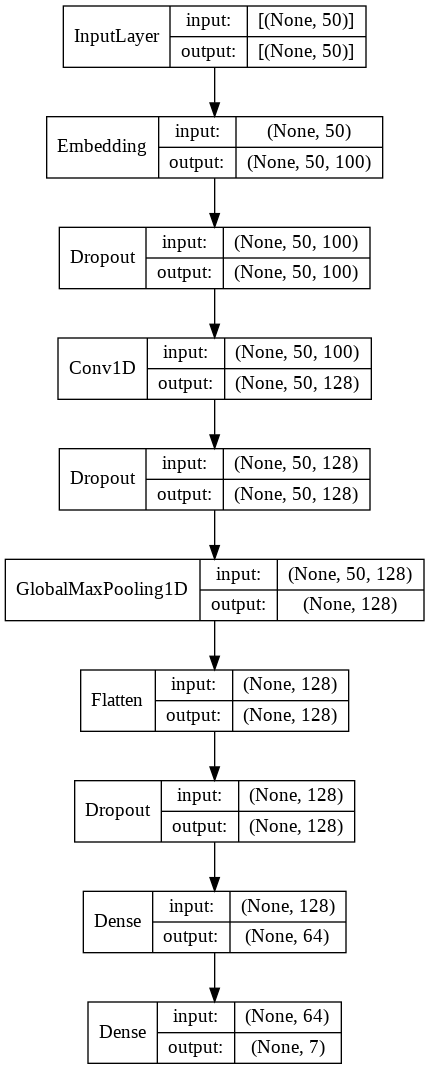

In [ ]:
from keras.utils.vis_utils import plot_model
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=False)

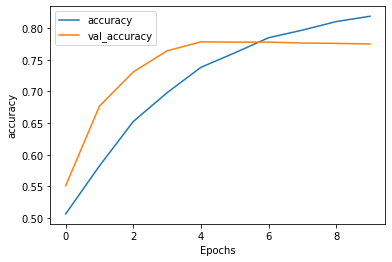

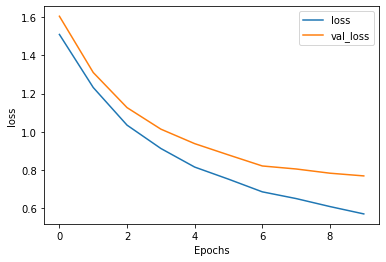

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
text = ["saya takut"]

tokenized_text = tokenizer.texts_to_sequences(text)

In [ ]:
prediction = model.predict(tokenized_text)

In [ ]:
labels = ["Eksploitasi", "Eksploitasi Seksual", "Kekerasan Fisik", "Kekerasan Lainnya", "Kekerasan Psikis", "Kekerasan Seksual", "Penelantaran"]
predicted = prediction.argmax(axis=1)
predict_labels = [labels[predict] for predict in predicted]
print(prediction)
print(predict_labels)

[[0.00206113 0.02345051 0.00296443 0.1483927  0.79776305 0.00522542
  0.02014276]]
['Kekerasan Psikis']


In [ ]:
#Exporting the Model (TFLITE)
export_dir = 'saved_model_laporan/1'
tf.saved_model.save(model, export_dir)


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: saved_model_laporan/1/assets


In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

In [ ]:
import pathlib

tflite_model_laporan_file = pathlib.Path('/content/modellaporan.tflite')
tflite_model_laporan_file.write_bytes(tflite_model)

8141284

In [ ]:
from google.colab import files
files.download(tflite_model_laporan_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Exporting the Tokenized Word
import json

with open( 'word_dict_laporan.json' , 'w' ) as file:
    json.dump( tokenizer.word_index , file )